In [1]:
#Operating system
from pathlib import Path

#Data processing
import pandas as pd
import numpy as np

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Word cloud
from wordcloud import WordCloud
#plot graphs
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

#Feature extraction
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

#Cluster
from sklearn import cluster

In [2]:
#Import data
speech_df = pd.read_csv(Path.cwd() / "clean_speeches_df.txt")

In [3]:
#Feature Extraction with TF-IDF want to represent how important a word is to a set of documents
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(speech_df["content_nouns"])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

405 rows


,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,400,401,402,403,404
budget,0.353415,0.0,0.0,0.0,0.0,0.000000,0.000000,0.022172,0.0,0.0,...,0.0,0.011095,0.017076,0.019601,0.032958,0.000000,0.000000,0.000000,0.000000,0.000000
program,0.293598,0.0,0.0,0.0,0.0,0.262782,0.000000,0.017003,0.0,0.0,...,0.0,0.008508,0.000000,0.000000,0.160067,0.034677,0.117465,0.010202,0.022007,0.014561
deficit,0.248406,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.011583,0.000000,0.000000,0.000000,0.000000,0.010010
tax,0.240065,0.0,0.0,0.0,0.0,0.062073,0.012311,0.040163,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.059700,0.000000,0.053359,0.000000,0.008664,0.000000
cut,0.218272,0.0,0.0,0.0,0.0,0.028219,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.018094,0.000000,0.009703,0.000000,0.007877,0.015637


In [4]:
#Function of runing K-means Cluster Models
def run_KMeans(max_k, data):
        max_k += 1
        kmeans_results = dict()
        for k in range(2, max_k):
            kmeans = cluster.KMeans(n_clusters=k, init='k-means++', n_init=10, tol=0.0001, random_state=1, algorithm='lloyd')
            kmeans_results.update({k: kmeans.fit(data)})
        return kmeans_results

In [5]:
#Running Kmeans
k = 15
kmeans_results = run_KMeans(k, final_df)

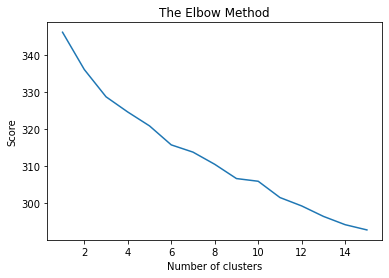

In [6]:
#Use the Elbow Method to find the best value of k
distortion_score = []
for i in range(1,k + 1):
    kmeans = cluster.KMeans(n_clusters = i, init = 'k-means++', n_init = 10, tol = 0.0001, random_state = 1, algorithm = 'lloyd')
    kmeans.fit(tf_idf)
    distortion_score.append(kmeans.inertia_)
plt.plot(range(1,k + 1 ),distortion_score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

In [7]:
#Function of getting top feature cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

#Function of plotting the most common words in cluster
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [8]:
#Determine the best k value is equal to 9
best_k_value = 9

#Build K-means Model
kmeans = kmeans_results.get(best_k_value)

#Get top features cluster
final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)

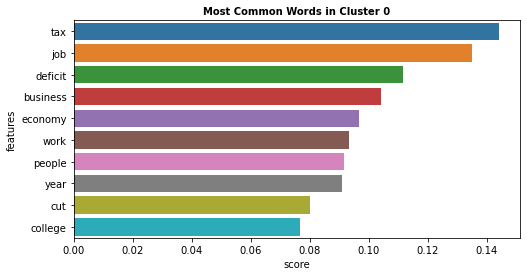

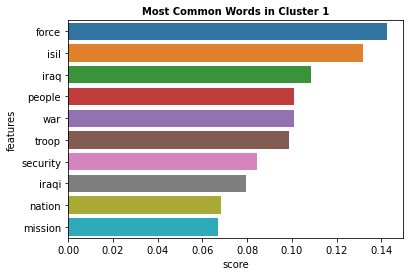

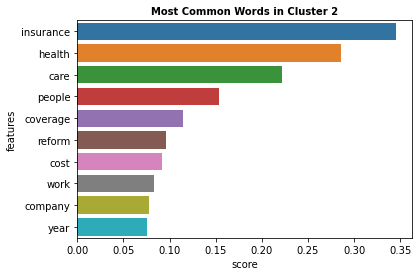

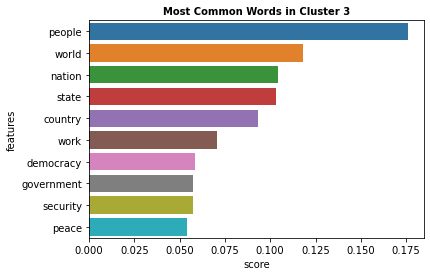

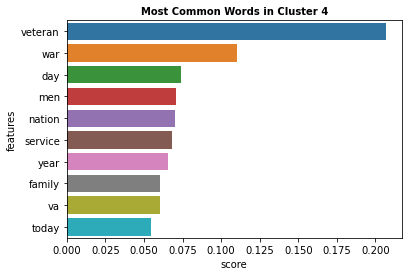

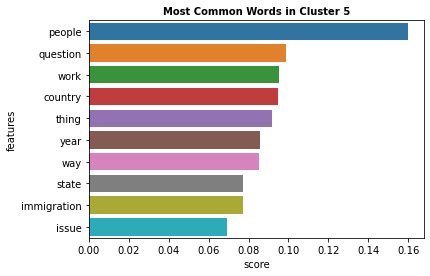

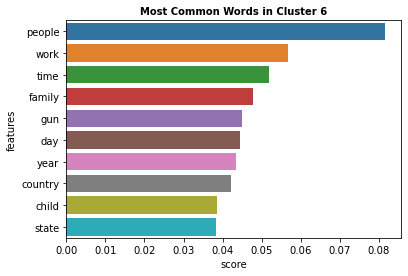

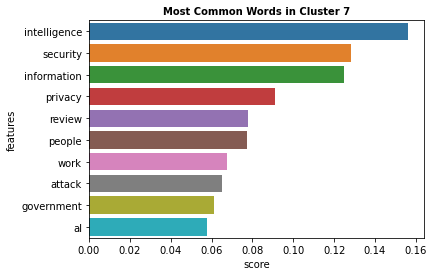

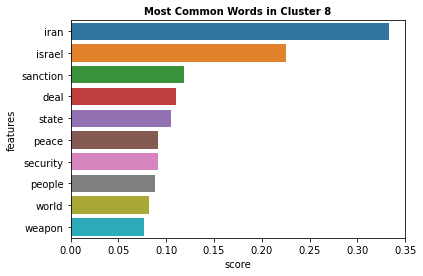

In [9]:
#Plot the most common words in cluster
plotWords(dfs, 10)

In [10]:
#Functions of generating Wordclouds
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending=False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update({a[i, 0]: a[i, 1]})
    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color='white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)
        
        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

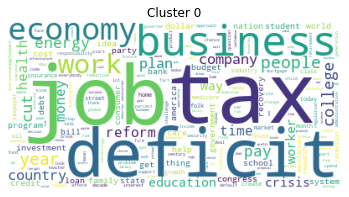

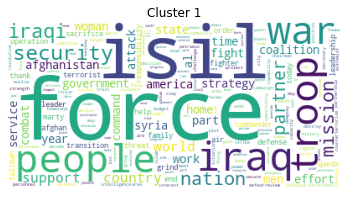

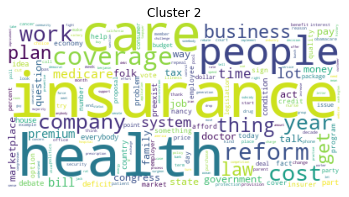

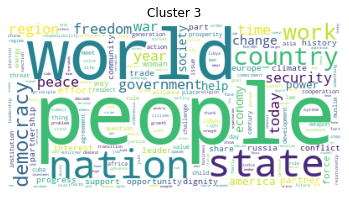

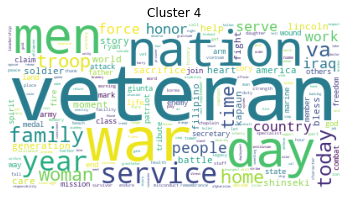

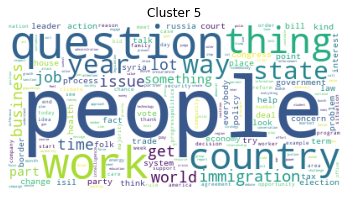

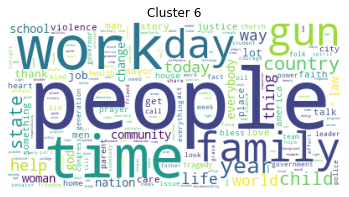

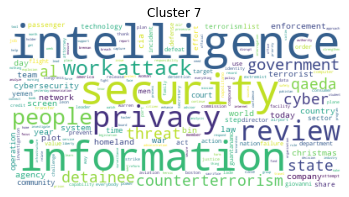

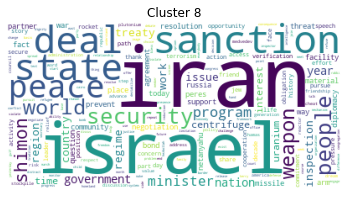

In [11]:
#Get the WordClouds of clusters
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)